### Monte Carlo Valuation

In this notebook, we will use Monte Carlo Simulation to price Asian options.  Using Monte Carlo simulation, we can create a sample stock path and use this to price the option.  Before we go over Monte Carlo simulation, lets review binomial option pricing.  

#### Binomial Option Pricing

Previously, when pricing using the binomial model, we did the following:

- create a stock price tree
- find the option payoff = price at expiration
- backtrack to find the options price at the beginning i.e. the previous periods option price is the discounted expected value

It is not hard to see that we can do this much quicker.  Recall, that we already know how to calculate the expiration stock prices:
Let

- $ S_0 = $ the inital stock price
- $n$ be the number of periods in the binomial tree
- $u, d$ be the up and down multiplier respectively
- $p^*$ be the risk-neutral probability

Then, the expiration stock prices, from highest to lowest are
$$S_0u^n, S_0u^{n-1}d, S_0u^{n-2}d^2, \ldots, S_0ud^{n-1}, S_0d^n$$

We also know how to calculate the probability of reaching any of these expiration nodes (just use the binomial theorem)
$$\mathbb{P}[S_T = S_0u^{n-k}d^k] = {n \choose k} p^{* (n-k)}(1 - p^*)^k $$

Instead of backtracking to find the option price, we can just discount the expected option payoff e.g., let

- $V(S, t)$ denote the option value/price at time $t$ if the asset price is $S$

Then, 

$$V(S_0, 0) = e^{-rT} \mathbb{E}[V(S_T, T)] = e^{-rT} \sum_{k = 0}^n  V(S_0 u^{n-k}d^k, T) {n\choose k} p^{* (n-k)} (1-p^*)^k$$

Here, $V(S_0 u^{n-k}d^k, T) = \max\{S_0 u^{n-k}d^k - K, 0\}$ for a call option and $V(S_0 u^{n-k}d^k, T) = \max\{K - S_0 u^{n-k}d^k, 0\}$ for a put option.

In [48]:
function binomialOptionPrice(kind::Symbol, r::Float64, delta::Float64, 
        sigma::Float64, S0::Float64, K::Float64, T::Float64, n::Integer)
    h = T / n
    u = exp( (r - delta) * h + sigma * sqrt(h))
    d = exp( (r - delta) * h - sigma * sqrt(h))

    p_star = (exp( (r - delta) * h) - d) / (u - d)

    prices = Array{Float64}(n + 1)
    probs = Array{Float64}(n + 1)
    payoffs = Array{Float64}(n + 1)
    for k in 1:n+1
        prices[k] = S0 * (u ^ (n-k)) * (d ^ k)
        probs[k] = binomial(BigInt(n), BigInt(k)) * p_star^(n-k) * (1 - p_star)^k
    end
    
    # calculate the payoffs of the option at expiration
    if kind == :Call
        payoffs = [maximum( (prices[k] - K, 0) ) for k in 1:n+1]
    elseif kind == :Put
        payoffs = [maximum( (K - prices[k], 0) ) for k in 1:n+1]
    end
        
    # return the option price
    expectedPayoff = dot(payoffs, probs)
    return exp(-r * T) * expectedPayoff
end
        
        

binomialOptionPrice (generic function with 3 methods)

In [49]:
r = 0.08
delta = 0.0
sigma = 0.3
S0 = 100.0
K = 100.0
T = 0.5
n = 100

callPrice = binomialOptionPrice(:Call, r, delta, sigma, S0, K, T, n)
println("Call option with initial data:")
println("r = $r, delta = $delta, sigma = $sigma, S0 = $S0, K = $K, T = $T, n = $n")
println("Call price = $callPrice\n\n")

putPrice = binomialOptionPrice(:Put, r, delta, sigma, S0, K, T, n)
println("Put option with initial data:")
println("r = $r, delta = $delta, sigma = $sigma, S0 = $S0, K = $K, T = $T, n = $n")
println("Put price = $putPrice")


Call option with initial data:
r = 0.08, delta = 0.0, sigma = 0.3, S0 = 100.0, K = 100.0, T = 0.5, n = 100
Call price = 10.376409436919415


Put option with initial data:
r = 0.08, delta = 0.0, sigma = 0.3, S0 = 100.0, K = 100.0, T = 0.5, n = 100
Put price = 6.455353352150828


#### Monte Carlo Valuation

For Monte Carlo valuation, we will do something similar as above.  We are going to calculate the option price as a discounted expected payoff.  With the binomial tree we had a formula (and an associated probability) for all of the future stock prices.  In this case, we will get a random sample of possible future stock prices and use these for the option payoffs.  So, let

- $S_T^0, S_T^1, S_T^2, \ldots, S_T^n$ be $n$ random draws of future stock prices 
- $V(S_T^k, T)$ is the option payoff at expiration if the stock price is $S_T^k$ e.g. $V(S_T^k, T) = \max \{S_T^k - K, 0 \}$ for a call and similarly for a put

Then, the original option price is the discounted expected payoff

$$ V(S_0, 0) = e^{-rT} \mathbb{E} [ V(S_T, T)] = e^{-rT} \frac{1}{n} \sum_{k = 0}^n V(S_T^k, T) $$

### Calculating Asian average price calls

To calculate the price of an average price call, we will follow the above method, but our payoff at expiration will be a bit different.  Let $V_A$ and $V_G$ denote the prices of arithmetic and geometric average price calls respectively.  Then,

$$V_A(S, T) = \max \{ \mathrm{Ave}_A(S) - K, 0 \} \qquad V_G(S, T) = \max \{ \mathrm{Ave}_G(S) - K, 0\}$$

where $\mathrm{Ave}_A$ and $\mathrm{Ave}_G$ denote the arithmetic and geometric average of $S$ respectively.

Lets fix some notation for our simulation

- `r` is the annualized risk-free rate (for valuation, we assume $\alpha = r$)
- `delta` is the annualized dividend yield
- `sigma` is the annualized volatility
- `S0` is the initial stock price
- `K` is the strike price
- `T` is the time to expiration (in years)
- `numAves` is the number of averages to take
- `numSims` is the number of simulations/trials to run (so `numSims` is $n$ above)
- `h` is `T/numAves`

We will calculate `numSims` stock paths following the log normal model.  Along each path, we will calculate `numAves`prices each of which will be a distance `h` apart.  We calculate the average price along a single path and use that to calculate the option payoff.  We then average all the payoffs (one per path).  This is the expected payoff above.  Finally, we discount this average for the final price.


In [5]:
using Plots

function avePriceAsianOption(r::Float64, delta::Float64, sigma::Float64,
         S0::Float64, K::Float64, T::Float64,  numAves::Integer, numSims::Integer, plotOrNot::Bool)

    mu = r - delta
    h = T / numAves
    
    # we keep track of the payoff for each simulation
    arithmeticPayoffs = Array{Float64}(numSims)
    geometricPayoffs = Array{Float64}(numSims)
    
    maxPrice = 0

    if plotOrNot
        p = plot(title= "$numSims stock price simulations with $numAves averages", ylabel= "Stock Price", xlabel="Time", legend=false)
    end

    for s in 1:numSims
        Zs = randn(numAves)
        prices = Array{Float64}(numAves+1)

        prices[1] = S0

        for i in 1:numAves
            logReturn = (mu - 1/2 * sigma^2)*h + sigma * sqrt(h) * Zs[i]

            prices[i+1] = prices[i] * exp(logReturn)
        end
        
        arithmeticAve = mean(prices[2:end])
        geometricAve = prod(prices[2:end])^(1/numAves)
        arithmeticPayoffs[s] = maximum((arithmeticAve - K, 0))
        geometricPayoffs[s] = maximum((geometricAve - K, 0))
        
        

        times = [i*h for i in 0:numAves]
        
        if plotOrNot
            plot!(p, times, prices)
            #update the maxPrice (for a better plot)
            mp = maximum(prices)
            maxPrice = (mp > maxPrice) ? mp : maxPrice
        end
    end

    arithmeticPrice = exp(-r*T) * mean(arithmeticPayoffs)
    geometricPrice = exp(-r*T) * mean(geometricPayoffs)
    println("****************************")
    println("Arithmetic Price = $arithmeticPrice")
    println("Geometric Price = $geometricPrice")
    println("****************************")
    
    if plotOrNot
        plot!(p, ylim= [0, maxPrice + 10])
        display(p)
    end
end


avePriceAsianOption (generic function with 1 method)

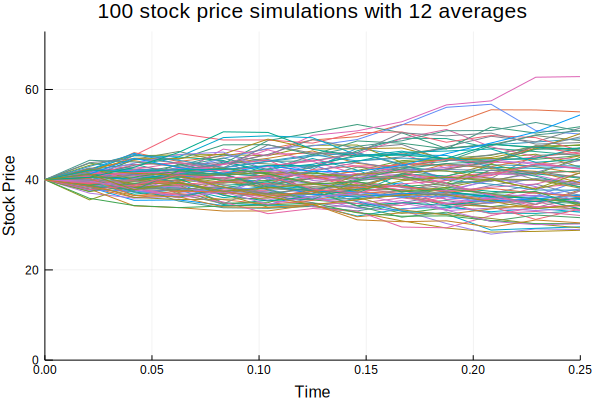

****************************
Arithmetic Price = 1.7153033871056191
Geometric Price = 1.6733190898797479
****************************


In [6]:
#Asian average price options using the configuration from Table 19.3 plotting the sample paths

avePriceAsianOption(0.08, 0.0, 0.3, 40.0, 40.0, 0.25, 12, 100, true)

In [52]:
#Asian average price options using the configuration from Table 19.3 not plotting sample paths, but doing more simulations

avePriceAsianOption(0.08, 0.0, 0.3, 40.0, 40.0, 0.25, 12, 10000, false)

****************************
Arithmetic Price = 1.6746480532284136
Geometric Price = 1.631249164115283
****************************
